# Includes

In [ ]:
import os
import sys
import time
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.utils
import torch.nn.functional as F
import torchvision.datasets as dset
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
from torch.autograd import Variable
from timeit import default_timer as timer
from tqdm import tqdm_notebook
from collections import defaultdict,Counter
import pickle

import scipy.io

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
cd /content/drive/My Drive/Colab Notebooks/huawei

/content/drive/My Drive/Colab Notebooks/huawei


In [ ]:
!git clone https://github.com/Huawei-Sirius-Summer-2020/DPDBlocks.git

Cloning into 'DPDBlocks'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 14 (delta 1), reused 14 (delta 1), pack-reused 0
Unpacking objects: 100% (14/14), done.


In [ ]:
!git clone https://github.com/Huawei-Sirius-Summer-2020/AdaptiveFilterLectures.git

Cloning into 'AdaptiveFilterLectures'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 32 (delta 0), reused 2 (delta 0), pack-reused 29
Unpacking objects: 100% (32/32), done.
Checking out files: 100% (27/27), done.


In [ ]:
from DPDBlocks.blocks import AFIR,ABS,Polynomial,Delay,Prod_cmp

In [ ]:
import matplotlib.pyplot as plt

import matplotlib.mlab as mlab
import matplotlib.gridspec as gridspec

# Operations

In [ ]:
def NMSE(X, E):
    return 10*torch.log10((E.norm(dim=1)**2).sum()/(X.norm(dim=1)**2).sum())

In [ ]:
def update_history(hist, iter_num, val_acc, val_loss, time):
    hist['iter'].append(iter_num)
    hist['time'].append(time)
    hist['train_loss'].append(val_loss.item())
        # self.hist['norm_coeffs'].append(train_loss.item())
    hist['train_loss_db'].append(val_acc.item())

## Train Function

In [ ]:
def train_of_epoch(train_queue, model, criterion, optimizer):
    for step, (train) in enumerate(train_queue):

        input_batch = Variable(train[:,:,:1],requires_grad=False).permute(2,1,0).cuda()
        desired = Variable(train[:,:,1:],requires_grad=False).permute(2,1,0).cuda()
        optimizer.zero_grad()
        out = model.forward(input_batch)
        loss = criterion(out, desired)

        loss.backward()

        optimizer.step()


In [ ]:
def eval_model(valid_queue, model, criterion):
    for step, (valid) in enumerate(valid_queue):
        model.eval()
        input_batch = Variable(valid[:,:,:1],requires_grad=False).permute(2,1,0).cuda()
        desired = Variable(valid[:,:,1:],requires_grad=False).permute(2,1,0).cuda()
        out = model.forward(input_batch)


        loss=criterion(out,desired)
        plt.psd(input_batch.detach().cpu()[0,0,:]+
                1j*input_batch.detach().cpu()[0,1,:],NFFT=2048)
        plt.psd(desired.detach().cpu()[0,0,:]+
                1j*desired.detach().cpu()[0,1,:],NFFT=2048)
        # plt.psd(desired.permute(2,1,0).detach().cpu().reshape(-1,),NFFT=2048)
        plt.psd((out-desired).detach().cpu()[0,0,:]+
                1j*(out-desired).detach().cpu()[0,1,:],NFFT=2048)
        # plt.psd((out-desired).permute(2,1,0).detach().cpu().reshape(-1,),NFFT=2048)
        plt.show()

        
        accuracy = NMSE(input_batch, out-desired)
#         print('Loss = ',loss.cpu().detach().numpy(), 'Accuracy = ', accuracy.cpu().detach().numpy(), 'dbs')
    return loss,accuracy
#     return model

In [ ]:
def train(train_queue, valid_queue, model, criterion, optimizer,n_epoch,
          scheduler,log_every=1,save_flag=True,path_to_experiment='/content/drive/My Drive/Colab Notebooks/huawei/new_folder'):
    min_loss=0
    hist=defaultdict(list)
    t0=timer()
    for it in tqdm_notebook(range(n_epoch)):
        model.train(True)
        train_of_epoch(train_queue, model, criterion, optimizer)
        scheduler.step()

    #     if return_history and it % log_every == 0:
    #         model.init_for_batch(train)
    #         train_loss = complex_mse(model.forward(train.x), train.y)
        if it%log_every==0:
            loss_v,accuracy_v=eval_model(valid_queue,net, loss_fn)
            update_history(hist,it, accuracy_v, loss_v, timer() - t0,)
            print('Loss = ',loss_v.cpu().detach().numpy(), 'Accuracy = ', accuracy_v.cpu().detach().numpy(), 'dbs')
            
            if save_flag:
                with open(path_to_experiment + '/hist.pkl', 'wb') as output:
                    pickle.dump(hist, output)

                    torch.save(model.state_dict(), path_to_experiment + '/model.pt')
                if hist['train_loss_db'][-1] < min_loss:
                            min_loss = hist['train_loss_db'][-1]
                            torch.save(model.state_dict(), path_to_experiment + '/best_model.pth')

In [ ]:
global cur_epoh
cur_epoh = 0
global Batch_size
Batch_size=6000

In [ ]:
def my_train(train_queue, valid_queue, model, criterion, optimizer,n_epoch,X, D,
          scheduler,log_every=1,save_flag=True,path_to_experiment=''):
    min_loss=0
    global Batch_size
    global cur_epoh
    hist=defaultdict(list)
    t0=timer()
    cur_epoh = 0
    for it in tqdm_notebook(range(n_epoch)):
        model.train(True)
        train_of_epoch(train_queue, model, criterion, optimizer)
        scheduler.step()
        cur_epoh += 1

        if Batch_size == 13000: # запуск новой учёбы заново
          Batch_size = 3000
          new_train_queue = change_batch(X, D, Batch_size)
          cur_epoh = 0
          my_train(new_train_queue, valid_queue, model, criterion, optimizer,n_epoch,X, D,
            scheduler,log_every=5,save_flag=True,path_to_experiment='/content/drive/My Drive/Colab Notebooks/huawei/new_folder')

        
        if cur_epoh % 100 == 0: #смена размера batch
          Batch_size += 1000
          new_train_queue = change_batch(X, D, Batch_size)
          cur_epoh = 0
          my_train(new_train_queue, valid_queue, model, criterion, optimizer,n_epoch,X, D,
            scheduler,log_every=5,save_flag=True,path_to_experiment='/content/drive/My Drive/Colab Notebooks/huawei/new_folder')

          
        

        if it%log_every==0:
            loss_v,accuracy_v=eval_model(valid_queue,net, loss_fn)
            update_history(hist,it, accuracy_v, loss_v, timer() - t0,)
            print('Loss = ',loss_v.cpu().detach().numpy(), 'Accuracy = ', accuracy_v.cpu().detach().numpy(), 'dbs')
            print('cur_batch = ', Batch_size)

            if save_flag:
                with open(path_to_experiment + '/hist.pkl', 'wb') as output:
                    pickle.dump(hist, output)

                    torch.save(model.state_dict(), path_to_experiment + '/n_model.pt')
                if hist['train_loss_db'][-1] < min_loss:
                            min_loss = hist['train_loss_db'][-1]
                            torch.save(model.state_dict(), path_to_experiment + '/best_n_model.pth')

In [ ]:
def change_batch(X, D, Batch_size):
  train_queue = torch.utils.data.DataLoader(
    torch.cat((X,D),dim=-1), batch_size=Batch_size)#, pin_memory=True)

  # valid_queue = torch.utils.data.DataLoader(
  #   torch.cat((X,D),dim=-1), batch_size=X.shape[0])#,pin_memory=True)
  return train_queue

In [ ]:
def draw_spectrum(input_batch,desired,out):
  plt.psd(input_batch.detach().cpu()[0,0,:]+
                1j*input_batch.detach().cpu()[0,1,:],NFFT=2048)
  plt.psd(desired.detach().cpu()[0,0,:]+
                1j*desired.detach().cpu()[0,1,:],NFFT=2048)
        # plt.psd(desired.permute(2,1,0).detach().cpu().reshape(-1,),NFFT=2048)
  plt.psd((out-desired).detach().cpu()[0,0,:]+
                1j*(out-desired).detach().cpu()[0,1,:],NFFT=2048)
        # plt.psd((out-desired).permute(2,1,0).detach().cpu().reshape(-1,),NFFT=2048)
  plt.show()



# Data preprocess

In [ ]:
np.random.seed()
# torch.cuda.set_device()
cudnn.benchmark = True
torch.manual_seed(10)
cudnn.enabled=True
torch.cuda.manual_seed(10)

In [ ]:
Batch_size=10000

In [ ]:
name = 'BlackBoxData_80'
# name = 'BlackBoxData'
# name = '../BlackBoxData/data1'
mat = scipy.io.loadmat(name)
x = np.array(mat['x']).reshape(-1,1)/2**15
d = np.array(mat['y']).reshape(-1,1)/2**15
# x = np.array(mat['xE']).reshape(-1,1)/2**15
# d = np.array(mat['d']).reshape(-1,1)/2**15
# x, d = mat['xE'], mat['d']

x_real, x_imag = torch.from_numpy(np.real(x)), torch.from_numpy(np.imag(x))
d_real, d_imag = torch.from_numpy(np.real(d)), torch.from_numpy(np.imag(d))
print(x_real.shape)

X = torch.DoubleTensor(torch.cat((x_real, x_imag), dim=1)).reshape(-1,2,1)
D = torch.DoubleTensor(torch.cat((d_real, d_imag), dim=1)).reshape(-1,2,1)

train_queue = torch.utils.data.DataLoader(
    torch.cat((X,D),dim=-1), batch_size=Batch_size)#, pin_memory=True)

valid_queue = torch.utils.data.DataLoader(
    torch.cat((X,D),dim=-1), batch_size=X.shape[0])#,pin_memory=True)

torch.Size([99840, 1])


In [ ]:
gamma=0.95
step_size=5

In [ ]:
X.shape

torch.Size([99840, 2, 1])

In [ ]:
X.detach().cpu()).shape

In [ ]:
np.complex(X.detach().cpu()[0,:,:])

In [ ]:
# X.shape
X.detach().cpu()[,0,:]+1j*X.detach().cpu()[0,1,:]

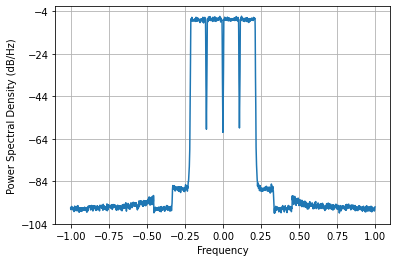

In [ ]:
plt.psd(X.detach().cpu()[:,0,0]+1j*X.detach().cpu()[:,1,0],NFFT=2048)
# plt.psd(d.reshape(-1,),NFFT=2048)
# plt.psd(x.reshape(-1,)*x.reshape(-1,),NFFT=2048)
plt.show()

## Loss function

In [ ]:
loss_fn = nn.MSELoss()

# Model

In [ ]:
class Cell_1(nn.Module):
    def __init__(self,M=15,D=0,Poly_order=8,Passthrough=False):
        super(Cell_1,self).__init__()
        self.f=AFIR(M,0)
        self.pol=Polynomial(Poly_order,Passthrough)
    def forward(self,x):
        return self.pol(self.f(x))

In [ ]:
net=Cell_1()
# net
net=net.to("cuda:0")
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
train(train_queue, valid_queue, net, loss_fn, optimizer,20,scheduler,save_flag=False)

In [ ]:
class Cell_2(nn.Module):
    def __init__(self,M=15,D=0,Poly_order=8,Passthrough=False):
        super(Cell_2,self).__init__()
        self.f=AFIR(M,0)
        self.pol=Polynomial(Poly_order,Passthrough)
        self.prod=Prod_cmp()
    def forward(self,x):
        return self.prod(x,self.pol(self.f(x)))

In [ ]:
plt.psd(input_batch.permute(2,1,0).detach().cpu().reshape(-1,),NFFT=2048)
plt.psd(desired.permute(2,1,0).detach().cpu().reshape(-1,),NFFT=2048)
plt.psd((out-desired).permute(2,1,0).detach().cpu().reshape(-1,),NFFT=2048)
plt.show()

In [ ]:
def eval_model(valid_queue, model,criterion):
    for step, (valid) in enumerate(valid_queue):
        model.eval()
        input_batch = Variable(valid[:,:,:1],requires_grad=False).permute(2,1,0).cuda()
        desired = Variable(valid[:,:,1:],requires_grad=False).permute(2,1,0).cuda()
        out = model.forward(input_batch)


        loss=criterion(out,desired)
        # print(input_batch.shape)
        
        # print(input_batch.shape)


        
        accuracy = NMSE(input_batch, out-desired)
#         print('Loss = ',loss.cpu().detach().numpy(), 'Accuracy = ', accuracy.cpu().detach().numpy(), 'dbs')
    return loss,accuracy
#     return model

In [ ]:
net=Cell_2()
# net
net=net.to("cuda:0")
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
train(train_queue, valid_queue, net, loss_fn, optimizer,20,scheduler,save_flag=False)

In [ ]:
net=Cell()
# net
net=net.to("cuda:0")
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
train(train_queue, valid_queue, net, loss_fn, optimizer,20,scheduler,save_flag=False)

In [ ]:
net=layer([0,10,50],3)
# net
net=net.to("cuda:0")
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=1)
train(train_queue, valid_queue, net, loss_fn, optimizer,100,scheduler,save_flag=False)

In [ ]:
class LowModel(nn.Module):
    def __init__(self, layers, width, delay):
        super(LowModel, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(layers):
            self.layers.append(layer(delay[i], width))
    def forward(self, x):
        out = x.clone()
        for i in range(len(self.op)):
            out = self.op[i](out)
        return out

In [ ]:
model = LowModel(3,5,[[0,1,2,3,4],[5,6,7,8,9],[4,3,2,1,10]])
# net
net=net.to("cuda:0")
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=1)
train(train_queue, valid_queue, net, loss_fn, optimizer,100,scheduler,save_flag=False)

# **Мои доработки**

In [ ]:
    for step, (valid) in enumerate(train_queue):
        # model.eval()
        input_batch = Variable(valid[:,:,:1],requires_grad=False).permute(2,1,0).cuda()
        desired = Variable(valid[:,:,1:],requires_grad=False).permute(2,1,0).cuda()
        break

In [ ]:
pip install torch-summary

In [ ]:
net

In [ ]:
torch.summ(net)

In [ ]:
input_batch.shape[2]

1000

In [ ]:
abs = ABS()
x = abs(input_batch).view(1, -1)
x.shape

torch.Size([1, 1000])

In [ ]:
out = torch.zeros_like(input_batch)
weights = nn.Parameter(torch.zeros((2, 8), dtype=torch.float64), requires_grad=False)
abs = ABS()
x = abs(input_batch).view(1, -1)
for i in range(8):
    out[:, 0] += weights[0, i]*torch.pow(x,i)
    out[:, 1] += weights[1, i]*torch.pow(x,i)
out.shape


torch.Size([1, 2, 1000])

Доработка уже существующей архитектуры


In [ ]:
class Cell(nn.Module):
    def __init__(self,M=15,D=0,Poly_order=8,Passthrough=False):
        super(Cell,self).__init__()
        self.f1=AFIR(M,0)
        self.f2=AFIR(M,0)
        self.delay=Delay(D)
        self.pol=Polynomial(Poly_order,True) # было Passthrough
        self.prod=Prod_cmp()
    def forward(self,x):
        x=self.delay(x)
        up=self.f1(x) 
        return self.prod(up,self.f2(self.pol(x)))

In [ ]:
class Sasha_Cell(nn.Module):
    def __init__(self,M=15,D=0,Poly_order=8,Passthrough=False):
        super(Sasha_Cell,self).__init__()
        self.f1=AFIR(M,0)
        self.f2=AFIR(M,1)
        self.f3=AFIR(M,0)
        self.f4=AFIR(M,1)
        self.pol1=Polynomial(Poly_order,True) # было Passthrough
        self.pol2=Polynomial(Poly_order,True) # было Passthrough
        self.delay=Delay(D)
        self.prod=Prod_cmp()
    def forward(self,x):
        x=self.delay(x)
        lis = self.f1(self.pol1(x)) + self.f2(x)
        sah = self.f3(self.pol2(x)) + self.f4(x)
        return self.prod(lis, sah)

In [ ]:
class my_Cell1(nn.Module):
    def __init__(self,M=15,D=0,Poly_order=8,Passthrough=False):
        super(my_Cell1,self).__init__()
        self.f=AFIR(M,0)
        self.delay=Delay(D)
        self.poly=Polynomial(Poly_order,True) # было Passthrough
    def forward(self,x):
        x=self.delay(x)
        up=self.f(self.poly(x)) 
        return up

In [ ]:
class my_Cell2(nn.Module):
    def __init__(self,M=15,D=0,Poly_order=8,Passthrough=False):
        super(my_Cell2,self).__init__()
        self.delay=Delay(D)
        self.poly=Polynomial(Poly_order,True) # было Passthrough
    def forward(self,x):
        x=self.delay(x)
        return self.poly(x)

In [ ]:
class Liza_layer(nn.Module):
    def __init__(self, delay):
        super(Liza_layer, self).__init__()
        self.Cells = nn.ModuleList()
        self.Cells.append(Cell(D=delay[0]))
        self.Cells.append(Sasha_Cell(D=delay[1]))
        self.Cells.append(my_Cell1(D=delay[2]))
        self.Cells.append(my_Cell2(D=delay[3]))
        self.Cells.append(Cell(D=delay[4]))
        self.Cells.append(Sasha_Cell(D=delay[5]))
        self.Cells.append(my_Cell1(D=delay[6]))
        self.Cells.append(my_Cell2(D=delay[7]))

    def forward(self, x):
        out = torch.zeros_like(x)
        for i in range(len(self.Cells)):
            out += self.Cells[i](x)
        return out

In [ ]:
class sasha_layer(nn.Module):
    def __init__(self, delay,sasha_delay, width):
        super(sasha_layer, self).__init__()
        self.Cells = nn.ModuleList()
        for i in range(width):
            self.Cells.append(Cell(D=delay[i]))
            self.Cells.append(Sasha_Cell(D=sasha_delay[i]))

    def forward(self, x):
        out = torch.zeros_like(x)
        for i in range(len(self.Cells)):
            out += self.Cells[i](x)
        return out

In [ ]:
net = sasha_layer([1,0,1],[0,1,0],3)
# net
net=net.to("cuda:0")
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.999)
my_train(train_queue, valid_queue, net, loss_fn, optimizer,102,X,D,scheduler,save_flag=False)

In [ ]:
class Sasha_Model(nn.Module):
    def __init__(self, layers, width, delay, sasha_delay):
        super(Sasha_Model, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(layers):
            self.layers.append(sasha_layer(delay[i], sasha_delay[i], width))
    def forward(self, x):
        out = x.clone()
        for i in range(len(self.layers)):
            out = self.layers[i](out) + x
        return out

In [ ]:
class Liza_Model(nn.Module):
    def __init__(self, layers, delay):
        super(Liza_Model, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(layers):
            self.layers.append(Liza_layer(delay[i]))
        self.layers.append(sasha_layer([1,0,1],[0,1,0],3)
    def forward(self, x):
        out = x.clone()
        for i in range(len(self.layers)):
            out = self.layers[i](out) + x
        return out

In [ ]:
#net = Liza_Model(1,[[2,10,5,1,0,14,2,1]])  #[1,0,1],[0,1,0]
net=net.to("cuda:0")
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.99)
my_train(train_queue, valid_queue, net, loss_fn, optimizer,152,X,D,scheduler,save_flag=True)

In [ ]:
#net = Sasha_Model(2,4,[[3,0,5,2],[4,2,6,1]],[[2,7,3,0],[5,1,3,7]])  #[1,0,1],[0,1,0]
# net
net=net.to("cuda:0")
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.97)
my_train(train_queue, valid_queue, net, loss_fn, optimizer,102,X,D,scheduler,save_flag=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


Loss =  9.460302048399719e-05 Accuracy =  -25.286350239165568 dbs
cur_batch =  1000
Loss =  5.533398768263571e-05 Accuracy =  -27.61548057609813 dbs
cur_batch =  1000
Loss =  5.821458260689005e-05 Accuracy =  -27.39508238732173 dbs
cur_batch =  1000
Loss =  3.8988854442629714e-05 Accuracy =  -29.13599551606773 dbs
cur_batch =  1000
Loss =  3.473524227910854e-05 Accuracy =  -29.637696942533623 dbs
cur_batch =  1000
Loss =  2.8144994921211688e-05 Accuracy =  -30.551388520608164 dbs
cur_batch =  1000
Loss =  2.7162989717702103e-05 Accuracy =  -30.70562457455246 dbs
cur_batch =  1000
Loss =  2.377913874919786e-05 Accuracy =  -31.283439057261845 dbs
cur_batch =  1000
Loss =  2.2549204227419156e-05 Accuracy =  -31.514088066710997 dbs
cur_batch =  1000
Loss =  2.1396336346906642e-05 Accuracy =  -31.742006103733964 dbs
cur_batch =  1000
Loss =  1.923462055276497e-05 Accuracy =  -32.20456403420799 dbs
cur_batch =  1000
Loss =  1.932081972990589e-05 Accuracy =  -32.185144782825425 dbs
cur_batch 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


Loss =  7.3685050730870275e-06 Accuracy =  -36.37160639828323 dbs
cur_batch =  2000
Loss =  6.596346189000941e-06 Accuracy =  -36.852365865035864 dbs
cur_batch =  2000
Loss =  6.6306983125981405e-06 Accuracy =  -36.829807581118445 dbs
cur_batch =  2000
Loss =  6.3140770972757936e-06 Accuracy =  -37.042301461993425 dbs
cur_batch =  2000
Loss =  6.813373908164919e-06 Accuracy =  -36.71177803638032 dbs
cur_batch =  2000
Loss =  6.370217351899472e-06 Accuracy =  -37.003857759666715 dbs
cur_batch =  2000
Loss =  6.977874808369876e-06 Accuracy =  -36.608168532817714 dbs
cur_batch =  2000
Loss =  6.328201018236961e-06 Accuracy =  -37.032597604140896 dbs
cur_batch =  2000
Loss =  7.296312072954138e-06 Accuracy =  -36.41436625619046 dbs
cur_batch =  2000
Loss =  6.466831114700062e-06 Accuracy =  -36.93848507462406 dbs
cur_batch =  2000
Loss =  6.229138346647027e-06 Accuracy =  -37.10112050201929 dbs
cur_batch =  2000
Loss =  6.181016403515806e-06 Accuracy =  -37.13480130540683 dbs
cur_batch =  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


Loss =  5.397929994629633e-06 Accuracy =  -37.723127787654775 dbs
cur_batch =  3000
Loss =  5.500058788919487e-06 Accuracy =  -37.641726950909224 dbs
cur_batch =  3000
Loss =  5.344411533352094e-06 Accuracy =  -37.76640134147664 dbs
cur_batch =  3000
Loss =  5.402626774699465e-06 Accuracy =  -37.719350601275984 dbs
cur_batch =  3000
Loss =  5.525772224134613e-06 Accuracy =  -37.6214704763511 dbs
cur_batch =  3000
Loss =  5.440902839046457e-06 Accuracy =  -37.68869056129277 dbs
cur_batch =  3000
Loss =  5.221020444946839e-06 Accuracy =  -37.86784632824348 dbs
cur_batch =  3000
Loss =  5.098262335446424e-06 Accuracy =  -37.971178479862274 dbs
cur_batch =  3000
Loss =  5.12154451319953e-06 Accuracy =  -37.95139075008023 dbs
cur_batch =  3000
Loss =  5.208415833288798e-06 Accuracy =  -37.87834376225388 dbs
cur_batch =  3000
Loss =  5.221536167410875e-06 Accuracy =  -37.86741736160471 dbs
cur_batch =  3000
Loss =  5.1622304468112035e-06 Accuracy =  -37.91702638734439 dbs
cur_batch =  3000
L

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


Loss =  5.129216619648727e-06 Accuracy =  -37.944889858928 dbs
cur_batch =  4000
Loss =  4.58683060994859e-06 Accuracy =  -38.43027324603553 dbs
cur_batch =  4000
Loss =  4.546571919964865e-06 Accuracy =  -38.468559613217145 dbs
cur_batch =  4000
Loss =  4.518680088408869e-06 Accuracy =  -38.49528431264705 dbs
cur_batch =  4000
Loss =  4.497030235792447e-06 Accuracy =  -38.51614219130595 dbs
cur_batch =  4000
Loss =  4.478646019251712e-06 Accuracy =  -38.53393288414301 dbs
cur_batch =  4000
Loss =  4.455542653210241e-06 Accuracy =  -38.55639421134046 dbs
cur_batch =  4000
Loss =  4.424067276384332e-06 Accuracy =  -38.5871830406512 dbs
cur_batch =  4000
Loss =  4.4078004622481406e-06 Accuracy =  -38.60318100578175 dbs
cur_batch =  4000
Loss =  4.3932300799091875e-06 Accuracy =  -38.61756078187685 dbs
cur_batch =  4000
Loss =  4.3784928505129655e-06 Accuracy =  -38.63215381788151 dbs
cur_batch =  4000
Loss =  4.363868255562053e-06 Accuracy =  -38.64668395850318 dbs
cur_batch =  4000
Loss

In [ ]:
model = Sasha_Model(2,4,[[3,0,5,2],[4,2,6,1]],[[2,7,3,0],[5,1,3,7]])
model.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/huawei/new_folder/best_n_model.pth'))
model.eval()

In [ ]:
! pip install torch_optimizer

     |████████████████████████████████| 51kB 4.0MB/s 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


Loss =  4.502542001031882e-06 Accuracy =  -38.51082253951511 dbs
cur_batch =  1000
Loss =  4.437656442224612e-06 Accuracy =  -38.57386350022881 dbs
cur_batch =  1000
Loss =  4.476923166576782e-06 Accuracy =  -38.535603856481146 dbs
cur_batch =  1000
Loss =  4.506049530502566e-06 Accuracy =  -38.507440655086505 dbs
cur_batch =  1000
Loss =  4.515928260047917e-06 Accuracy =  -38.49792992574542 dbs
cur_batch =  1000
Loss =  4.489173815677578e-06 Accuracy =  -38.52373605575236 dbs
cur_batch =  1000
Loss =  4.4961128582427045e-06 Accuracy =  -38.51702822637709 dbs
cur_batch =  1000
Loss =  4.500257330642285e-06 Accuracy =  -38.51302678672293 dbs
cur_batch =  1000
Loss =  4.503649740879028e-06 Accuracy =  -38.50975419604828 dbs
cur_batch =  1000
Loss =  4.5065244831535365e-06 Accuracy =  -38.50698291833925 dbs
cur_batch =  1000
Loss =  4.481288662277881e-06 Accuracy =  -38.53137106788436 dbs
cur_batch =  1000
Loss =  4.489209266934261e-06 Accuracy =  -38.52370175940967 dbs
cur_batch =  1000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


Loss =  4.053308308703235e-06 Accuracy =  -38.967303877439555 dbs
cur_batch =  2000
Loss =  4.0246854698320975e-06 Accuracy =  -38.998080808796985 dbs
cur_batch =  2000
Loss =  3.959487065851052e-06 Accuracy =  -39.06901098060431 dbs
cur_batch =  2000
Loss =  3.924465290451046e-06 Accuracy =  -39.107595343269466 dbs
cur_batch =  2000
Loss =  3.914002729788048e-06 Accuracy =  -39.119189024711396 dbs
cur_batch =  2000
Loss =  3.918228616519631e-06 Accuracy =  -39.11450254550613 dbs
cur_batch =  2000
Loss =  3.9268582398368815e-06 Accuracy =  -39.10494803229849 dbs
cur_batch =  2000
Loss =  3.943949913567765e-06 Accuracy =  -39.08608635733275 dbs
cur_batch =  2000
Loss =  3.96567179243662e-06 Accuracy =  -39.062232584810644 dbs
cur_batch =  2000
Loss =  3.881717342402849e-06 Accuracy =  -39.155161187950945 dbs
cur_batch =  2000
Loss =  3.872055204167932e-06 Accuracy =  -39.16598486240255 dbs
cur_batch =  2000
Loss =  3.862521862421292e-06 Accuracy =  -39.17669076080054 dbs
cur_batch =  20

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


Loss =  3.78180962221043e-06 Accuracy =  -39.26840364184641 dbs
cur_batch =  3000
Loss =  3.7690205062654833e-06 Accuracy =  -39.283115263482834 dbs
cur_batch =  3000
Loss =  3.741578578348794e-06 Accuracy =  -39.31485156245866 dbs
cur_batch =  3000
Loss =  3.7255783719825904e-06 Accuracy =  -39.33346322956356 dbs
cur_batch =  3000
Loss =  3.718266547503847e-06 Accuracy =  -39.341995073199186 dbs
cur_batch =  3000
Loss =  3.711840011845665e-06 Accuracy =  -39.34950777748627 dbs
cur_batch =  3000
Loss =  3.705913048876713e-06 Accuracy =  -39.35644801353505 dbs
cur_batch =  3000
Loss =  3.700351088588055e-06 Accuracy =  -39.36297094890759 dbs
cur_batch =  3000
Loss =  3.6951506175029115e-06 Accuracy =  -39.36907881381683 dbs
cur_batch =  3000
Loss =  3.690369727638751e-06 Accuracy =  -39.37470147621455 dbs
cur_batch =  3000
Loss =  3.6860107937596484e-06 Accuracy =  -39.37983424057109 dbs
cur_batch =  3000
Loss =  3.681869024103273e-06 Accuracy =  -39.384716914938785 dbs
cur_batch =  300

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


Loss =  3.6720475618591534e-06 Accuracy =  -39.39631728963168 dbs
cur_batch =  4000
Loss =  3.6740334844132058e-06 Accuracy =  -39.39396916626552 dbs
cur_batch =  4000
Loss =  3.69274587575392e-06 Accuracy =  -39.37190604917353 dbs
cur_batch =  4000
Loss =  3.719897825842884e-06 Accuracy =  -39.34009015376775 dbs
cur_batch =  4000
Loss =  3.7528393117188234e-06 Accuracy =  -39.30180057406473 dbs
cur_batch =  4000
Loss =  3.7839296778545257e-06 Accuracy =  -39.26596969995351 dbs
cur_batch =  4000
Loss =  3.8035835128682704e-06 Accuracy =  -39.2434707046431 dbs
cur_batch =  4000
Loss =  3.8069024508419322e-06 Accuracy =  -39.23968278217405 dbs
cur_batch =  4000
Loss =  3.796808083046353e-06 Accuracy =  -39.25121381241992 dbs
cur_batch =  4000
Loss =  3.7801468163635347e-06 Accuracy =  -39.27031359047224 dbs
cur_batch =  4000
Loss =  3.7624388204220426e-06 Accuracy =  -39.290705799253075 dbs
cur_batch =  4000
Loss =  3.7459924862949643e-06 Accuracy =  -39.30973124755239 dbs
cur_batch =  4

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


Loss =  3.585001483201855e-06 Accuracy =  -39.50050687006244 dbs
cur_batch =  5000
Loss =  3.58953310837549e-06 Accuracy =  -39.495020632471515 dbs
cur_batch =  5000
Loss =  3.588503241789199e-06 Accuracy =  -39.496266837859096 dbs
cur_batch =  5000
Loss =  3.587093951357989e-06 Accuracy =  -39.49797275040984 dbs
cur_batch =  5000
Loss =  3.5856107158838302e-06 Accuracy =  -39.499768895715846 dbs
cur_batch =  5000
Loss =  3.5841735390305328e-06 Accuracy =  -39.50150997456306 dbs
cur_batch =  5000
Loss =  3.582836043463583e-06 Accuracy =  -39.50313092105226 dbs
cur_batch =  5000
Loss =  3.581626409567465e-06 Accuracy =  -39.504597429767024 dbs
cur_batch =  5000
Loss =  3.58056153289162e-06 Accuracy =  -39.505888850967786 dbs
cur_batch =  5000
Loss =  3.579643273615172e-06 Accuracy =  -39.507002771448214 dbs
cur_batch =  5000
Loss =  3.578823708656046e-06 Accuracy =  -39.50799720934043 dbs
cur_batch =  5000
Loss =  3.5779051137644035e-06 Accuracy =  -39.50911207817124 dbs
cur_batch =  50

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


Loss =  3.6848089669521124e-06 Accuracy =  -39.38125049214768 dbs
cur_batch =  6000
Loss =  3.7046061607861414e-06 Accuracy =  -39.35797982062178 dbs
cur_batch =  6000
Loss =  3.6812431059940097e-06 Accuracy =  -39.38545527876328 dbs
cur_batch =  6000
Loss =  3.66246996940989e-06 Accuracy =  -39.40765954328947 dbs
cur_batch =  6000
Loss =  3.647021055192889e-06 Accuracy =  -39.42601756073194 dbs
cur_batch =  6000
Loss =  3.6342380671654137e-06 Accuracy =  -39.4412665355943 dbs
cur_batch =  6000
Loss =  3.623504323915183e-06 Accuracy =  -39.45411242791525 dbs
cur_batch =  6000
Loss =  3.614354613978095e-06 Accuracy =  -39.46509266582129 dbs
cur_batch =  6000
Loss =  3.6064553508830794e-06 Accuracy =  -39.4745946683902 dbs
cur_batch =  6000
Loss =  3.5995673431696455e-06 Accuracy =  -39.482897236337415 dbs
cur_batch =  6000
Loss =  3.5935154692031173e-06 Accuracy =  -39.49020507960171 dbs
cur_batch =  6000
Loss =  3.588168020206276e-06 Accuracy =  -39.496672554878785 dbs
cur_batch =  600

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


Loss =  3.549304704468043e-06 Accuracy =  -39.543967419676775 dbs
cur_batch =  7000
Loss =  3.5573454511999096e-06 Accuracy =  -39.534139854369165 dbs
cur_batch =  7000
Loss =  3.559585957823249e-06 Accuracy =  -39.531405418305624 dbs
cur_batch =  7000
Loss =  3.561669559584614e-06 Accuracy =  -39.52886402157845 dbs
cur_batch =  7000
Loss =  3.5604597185254216e-06 Accuracy =  -39.53033949971293 dbs
cur_batch =  7000
Loss =  3.553461493288803e-06 Accuracy =  -39.538884130707 dbs
cur_batch =  7000
Loss =  3.5461260424886063e-06 Accuracy =  -39.54785858710292 dbs
cur_batch =  7000
Loss =  3.5422564091419798e-06 Accuracy =  -39.55260031933265 dbs
cur_batch =  7000
Loss =  3.540206680836793e-06 Accuracy =  -39.5551140937241 dbs
cur_batch =  7000
Loss =  3.5388327504002907e-06 Accuracy =  -39.55679988858477 dbs
cur_batch =  7000
Loss =  3.5377623052091047e-06 Accuracy =  -39.55811376464975 dbs
cur_batch =  7000
Loss =  3.5368545501369822e-06 Accuracy =  -39.55922826464026 dbs
cur_batch =  70

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


Loss =  3.5296188152087058e-06 Accuracy =  -39.56812220844407 dbs
cur_batch =  8000
Loss =  3.529270846896726e-06 Accuracy =  -39.56855037979998 dbs
cur_batch =  8000
Loss =  3.5290642767397107e-06 Accuracy =  -39.56880458217993 dbs
cur_batch =  8000
Loss =  3.5288669658835482e-06 Accuracy =  -39.5690474040866 dbs
cur_batch =  8000
Loss =  3.5286774078802316e-06 Accuracy =  -39.56928069768137 dbs
cur_batch =  8000
Loss =  3.5284912394819447e-06 Accuracy =  -39.56950983180622 dbs
cur_batch =  8000
Loss =  3.528307085920227e-06 Accuracy =  -39.56973649798544 dbs
cur_batch =  8000
Loss =  3.5281247742521236e-06 Accuracy =  -39.56996090871605 dbs
cur_batch =  8000
Loss =  3.5279445247898483e-06 Accuracy =  -39.57018279244063 dbs
cur_batch =  8000
Loss =  3.5277666599403135e-06 Accuracy =  -39.5704017518642 dbs
cur_batch =  8000
Loss =  3.5275914975757985e-06 Accuracy =  -39.57061739519985 dbs
cur_batch =  8000
Loss =  3.527419314070495e-06 Accuracy =  -39.57082938168219 dbs
cur_batch =  80

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


Loss =  3.5261411558882253e-06 Accuracy =  -39.57240333019797 dbs
cur_batch =  9000
Loss =  3.5260143222556327e-06 Accuracy =  -39.57255954668223 dbs
cur_batch =  9000
Loss =  3.525940470317921e-06 Accuracy =  -39.57265051008166 dbs
cur_batch =  9000
Loss =  3.525820090719763e-06 Accuracy =  -39.57279878566409 dbs
cur_batch =  9000
Loss =  3.525691448289425e-06 Accuracy =  -39.57295724444936 dbs
cur_batch =  9000
Loss =  3.52556225549028e-06 Accuracy =  -39.57311638698525 dbs
cur_batch =  9000
Loss =  3.525434929120883e-06 Accuracy =  -39.57327323611789 dbs
cur_batch =  9000
Loss =  3.525310221378332e-06 Accuracy =  -39.573426864942334 dbs
cur_batch =  9000
Loss =  3.5251883820182435e-06 Accuracy =  -39.57357696542387 dbs
cur_batch =  9000
Loss =  3.5250694771102744e-06 Accuracy =  -39.57372345579752 dbs
cur_batch =  9000
Loss =  3.524953499450397e-06 Accuracy =  -39.57386634457357 dbs
cur_batch =  9000


KeyboardInterrupt: ignored

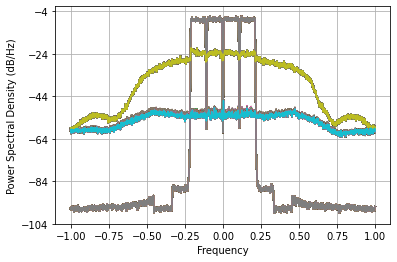

In [ ]:
net = model
net=net.to("cuda:0")
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.97)
my_train(train_queue, valid_queue, net, loss_fn, optimizer,102,X,D,scheduler,save_flag=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


Loss =  5.539783790181758e-06 Accuracy =  -37.61047211519975 dbs
cur_batch =  6000
Loss =  6.702844544855338e-06 Accuracy =  -36.78280879515067 dbs
cur_batch =  6000
Loss =  1.0675690110421595e-05 Accuracy =  -34.761440679128924 dbs
cur_batch =  6000
Loss =  7.677149420739122e-06 Accuracy =  -36.19340033304134 dbs
cur_batch =  6000
Loss =  1.14913081519052e-05 Accuracy =  -34.441705558053826 dbs
cur_batch =  6000
Loss =  7.587011840950483e-06 Accuracy =  -36.24469264825902 dbs
cur_batch =  6000
Loss =  8.102140800425496e-06 Accuracy =  -35.95940240529322 dbs
cur_batch =  6000
Loss =  7.0201845873993415e-06 Accuracy =  -36.581914951517305 dbs
cur_batch =  6000
Loss =  1.1701908629599914e-05 Accuracy =  -34.36283323942034 dbs
cur_batch =  6000
Loss =  6.892504155820178e-06 Accuracy =  -36.66162990053445 dbs
cur_batch =  6000
Loss =  6.356715699899023e-06 Accuracy =  -37.01307238370265 dbs
cur_batch =  6000
Loss =  7.021083131632541e-06 Accuracy =  -36.581359114522286 dbs
cur_batch =  600

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


Loss =  3.8057130658648686e-06 Accuracy =  -39.241039854090964 dbs
cur_batch =  7000
Loss =  3.723116834220749e-06 Accuracy =  -39.33633361766855 dbs
cur_batch =  7000
Loss =  3.591305065553898e-06 Accuracy =  -39.49287728591021 dbs
cur_batch =  7000
Loss =  3.5679057224880235e-06 Accuracy =  -39.52126656529039 dbs
cur_batch =  7000
Loss =  3.4325664174187227e-06 Accuracy =  -39.689210774467725 dbs
cur_batch =  7000
Loss =  3.346534019135558e-06 Accuracy =  -39.7994478251299 dbs
cur_batch =  7000
Loss =  3.3457224082412858e-06 Accuracy =  -39.80050121613005 dbs
cur_batch =  7000
Loss =  3.320271520247845e-06 Accuracy =  -39.83366426440916 dbs
cur_batch =  7000
Loss =  3.308850485734533e-06 Accuracy =  -39.848628831873356 dbs
cur_batch =  7000
Loss =  3.3228166198088652e-06 Accuracy =  -39.83033652668832 dbs
cur_batch =  7000
Loss =  3.388158281498132e-06 Accuracy =  -39.74576336016712 dbs
cur_batch =  7000
Loss =  3.268193481777249e-06 Accuracy =  -39.902322672058055 dbs
cur_batch =  7

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


Loss =  3.0532096032759663e-06 Accuracy =  -40.19783406987845 dbs
cur_batch =  8000
Loss =  3.070938877753839e-06 Accuracy =  -40.17268854113091 dbs
cur_batch =  8000
Loss =  3.064532682961989e-06 Accuracy =  -40.181757692643075 dbs
cur_batch =  8000
Loss =  3.057617919019528e-06 Accuracy =  -40.19156811808375 dbs
cur_batch =  8000
Loss =  2.9987235231272367e-06 Accuracy =  -40.27603600246905 dbs
cur_batch =  8000
Loss =  3.023968670570997e-06 Accuracy =  -40.2396273928652 dbs
cur_batch =  8000
Loss =  3.3553484773726317e-06 Accuracy =  -39.78802395196412 dbs
cur_batch =  8000
Loss =  3.271252649092954e-06 Accuracy =  -39.89825939344161 dbs
cur_batch =  8000
Loss =  3.1436139330444124e-06 Accuracy =  -40.071108217138686 dbs
cur_batch =  8000
Loss =  3.0781259771493674e-06 Accuracy =  -40.162536366439674 dbs
cur_batch =  8000
Loss =  3.070455427513083e-06 Accuracy =  -40.17337229391352 dbs
cur_batch =  8000
Loss =  3.0370244221040383e-06 Accuracy =  -40.22091742395134 dbs
cur_batch =  8

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


Loss =  2.8668504358085966e-06 Accuracy =  -40.471349903854005 dbs
cur_batch =  9000
Loss =  2.877779145541356e-06 Accuracy =  -40.4548256563286 dbs
cur_batch =  9000
Loss =  2.8709955321733517e-06 Accuracy =  -40.465075100377646 dbs
cur_batch =  9000
Loss =  2.862253229561818e-06 Accuracy =  -40.47831972618671 dbs
cur_batch =  9000
Loss =  2.8558005460596962e-06 Accuracy =  -40.48812154386095 dbs
cur_batch =  9000
Loss =  2.851288236247953e-06 Accuracy =  -40.494989044034774 dbs
cur_batch =  9000
Loss =  2.846396898013242e-06 Accuracy =  -40.50244569239724 dbs
cur_batch =  9000
Loss =  2.84136777479139e-06 Accuracy =  -40.51012576060995 dbs
cur_batch =  9000
Loss =  2.83811027950828e-06 Accuracy =  -40.515107600025075 dbs
cur_batch =  9000
Loss =  2.8360965042536595e-06 Accuracy =  -40.518190221265094 dbs
cur_batch =  9000
Loss =  2.8343710221978004e-06 Accuracy =  -40.52083327443529 dbs
cur_batch =  9000
Loss =  2.832463611611278e-06 Accuracy =  -40.52375687456574 dbs
cur_batch =  90

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


Loss =  2.9096383747356673e-06 Accuracy =  -40.40701010766256 dbs
cur_batch =  10000
Loss =  2.8367877634218612e-06 Accuracy =  -40.517131817710094 dbs
cur_batch =  10000
Loss =  2.827540554015989e-06 Accuracy =  -40.531311841750714 dbs
cur_batch =  10000
Loss =  2.819172523431385e-06 Accuracy =  -40.544183727103544 dbs
cur_batch =  10000
Loss =  2.8135781860939833e-06 Accuracy =  -40.55281038487586 dbs
cur_batch =  10000
Loss =  2.8097203591555998e-06 Accuracy =  -40.558769283201634 dbs
cur_batch =  10000
Loss =  2.8066486653353397e-06 Accuracy =  -40.56351975384708 dbs
cur_batch =  10000
Loss =  2.804346730334219e-06 Accuracy =  -40.567083177640114 dbs
cur_batch =  10000
Loss =  2.803161366871432e-06 Accuracy =  -40.5689192759914 dbs
cur_batch =  10000
Loss =  2.803591485949455e-06 Accuracy =  -40.56825294256306 dbs
cur_batch =  10000
Loss =  2.806361070650903e-06 Accuracy =  -40.56396479417469 dbs
cur_batch =  10000
Loss =  2.8121063613898963e-06 Accuracy =  -40.55508283849996 dbs
c

KeyboardInterrupt: ignored

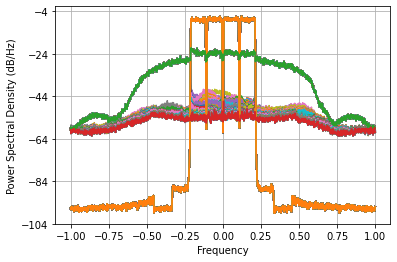

In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.95)
my_train(train_queue, valid_queue, net, loss_fn, optimizer,102,X,D,scheduler,save_flag=True)


In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.96)
train(train_queue, valid_queue, net, loss_fn, optimizer,302,scheduler,save_flag=True)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
net = Sasha_Model(3,3,[[3,2,1],[10,1,0],[1,0,1]],[[0,0,1],[0,1,0],[1,0,0]])  #[1,0,1],[0,1,0]
#net = Sasha_Model(3,3,[[3,2,3],[4,5,6],[7,5,9]],[[1,8,7],[6,5,4],[13,2,1]])
#net = Sasha_Model(3,3,[[50,2,3],[4,5,6],[7,5,40]],[[1,8,7],[6,5,4],[103,2,1]])
# net
net=net.to("cuda:0")
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.99)
my_train(train_queue, valid_queue, net, loss_fn, optimizer,102,X,D,scheduler,save_flag=False)

In [ ]:
class layer(nn.Module):
    def __init__(self, delay, width):
        super(layer, self).__init__()
        self.Cells = nn.ModuleList()
        for i in range(width):
#             print(i)
            self.Cells.append(Cell(D=delay[i]))

    def forward(self, x):
        out = torch.zeros_like(x)
        for i in range(len(self.Cells)):
            out += self.Cells[i](x)
        return out

In [ ]:
class Model(nn.Module):
    def __init__(self, layers, width, delay):
        super(Model, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(layers):
            self.layers.append(layer(delay[i], width))
    def forward(self, x):
        out = x.clone()
        for i in range(len(self.layers)):
            out = self.layers[i](out) + x
        return out

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


Loss =  0.13764731195829477 Accuracy =  6.342277080162072 dbs
cur_batch =  1000
Loss =  0.12108924925803177 Accuracy =  5.785655599298637 dbs
cur_batch =  1000
Loss =  0.10618911391450966 Accuracy =  5.215399701967101 dbs
cur_batch =  1000
Loss =  0.0940442475789993 Accuracy =  4.687922094437561 dbs
cur_batch =  1000
Loss =  0.08432757163015697 Accuracy =  4.214295674986131 dbs
cur_batch =  1000
Loss =  0.07639744802126318 Accuracy =  3.7853882496606577 dbs
cur_batch =  1000
Loss =  0.06963304449980735 Accuracy =  3.3827535714972057 dbs
cur_batch =  1000
Loss =  0.06354470154427072 Accuracy =  2.985393175642246 dbs
cur_batch =  1000
Loss =  0.05777267568863837 Accuracy =  2.5718245527071577 dbs
cur_batch =  1000
Loss =  0.05209572421716692 Accuracy =  2.1226205313541313 dbs
cur_batch =  1000
Loss =  0.04645428903932423 Accuracy =  1.6248579110576153 dbs
cur_batch =  1000
Loss =  0.040933023369527165 Accuracy =  1.0753379673079464 dbs
cur_batch =  1000
Loss =  0.03572368081052407 Accura

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


Loss =  0.0013506099899816288 Accuracy =  -13.740100689704049 dbs
cur_batch =  2000
Loss =  0.0012232755660906971 Accuracy =  -14.170157255376115 dbs
cur_batch =  2000
Loss =  0.0011158397593711866 Accuracy =  -14.569381946471573 dbs
cur_batch =  2000
Loss =  0.0010182322941546002 Accuracy =  -14.966931597277055 dbs
cur_batch =  2000
Loss =  0.0009331860154103117 Accuracy =  -15.345718047915963 dbs
cur_batch =  2000
Loss =  0.0008565567296725073 Accuracy =  -15.71783895151042 dbs
cur_batch =  2000
Loss =  0.0007872350968600397 Accuracy =  -16.08435578926445 dbs
cur_batch =  2000
Loss =  0.0007230364404695189 Accuracy =  -16.453798407408456 dbs
cur_batch =  2000
Loss =  0.0006644828491974923 Accuracy =  -16.82056250732305 dbs
cur_batch =  2000
Loss =  0.0006124504298570724 Accuracy =  -17.174690828936715 dbs
cur_batch =  2000
Loss =  0.0005652126622638945 Accuracy =  -17.52328144053576 dbs
cur_batch =  2000
Loss =  0.0005230153852017594 Accuracy =  -17.860255622761226 dbs
cur_batch =  2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


Loss =  0.00026832781730535394 Accuracy =  -20.758743287610336 dbs
cur_batch =  3000
Loss =  0.00025114069952034303 Accuracy =  -21.046229270984362 dbs
cur_batch =  3000
Loss =  0.0002373578841990177 Accuracy =  -21.29136364650038 dbs
cur_batch =  3000
Loss =  0.00022586677122351045 Accuracy =  -21.50687683044295 dbs
cur_batch =  3000
Loss =  0.00021523491587327446 Accuracy =  -21.716273017892483 dbs
cur_batch =  3000
Loss =  0.0002046405948916731 Accuracy =  -21.935482370546563 dbs
cur_batch =  3000
Loss =  0.00019447755479990751 Accuracy =  -22.156705412786202 dbs
cur_batch =  3000
Loss =  0.00018506771859194023 Accuracy =  -22.37209355423401 dbs
cur_batch =  3000
Loss =  0.00017677422847915257 Accuracy =  -22.571210762211038 dbs
cur_batch =  3000
Loss =  0.00016960153450461515 Accuracy =  -22.751102493815022 dbs
cur_batch =  3000
Loss =  0.00016226475815380413 Accuracy =  -22.9431581987049 dbs
cur_batch =  3000
Loss =  0.00015281847781337438 Accuracy =  -23.20364157218115 dbs
cur_ba

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


Loss =  0.0001025184422498994 Accuracy =  -24.937380281558635 dbs
cur_batch =  4000
Loss =  0.00010132747523507903 Accuracy =  -24.988128051671147 dbs
cur_batch =  4000
Loss =  9.996155878684809e-05 Accuracy =  -25.047070068523873 dbs
cur_batch =  4000
Loss =  9.728078127593852e-05 Accuracy =  -25.165129768641556 dbs
cur_batch =  4000
Loss =  9.479472210718408e-05 Accuracy =  -25.277558689233253 dbs
cur_batch =  4000
Loss =  9.244053146800931e-05 Accuracy =  -25.386775929863102 dbs
cur_batch =  4000
Loss =  9.015803605362947e-05 Accuracy =  -25.49535583947005 dbs
cur_batch =  4000
Loss =  8.765402247347176e-05 Accuracy =  -25.61768175876813 dbs
cur_batch =  4000
Loss =  8.436405853154003e-05 Accuracy =  -25.78382562360298 dbs
cur_batch =  4000
Loss =  8.209394459425977e-05 Accuracy =  -25.902289027756993 dbs
cur_batch =  4000
Loss =  7.988263343902568e-05 Accuracy =  -26.02087653148741 dbs
cur_batch =  4000
Loss =  7.769020086351076e-05 Accuracy =  -26.14173782395452 dbs
cur_batch =  4

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


Loss =  0.00010070618207504055 Accuracy =  -25.014838951746604 dbs
cur_batch =  5000
Loss =  6.27859332167782e-05 Accuracy =  -27.066776729293103 dbs
cur_batch =  5000
Loss =  6.155952520529784e-05 Accuracy =  -27.152447651310418 dbs
cur_batch =  5000
Loss =  5.706091156452612e-05 Accuracy =  -27.482013213321025 dbs
cur_batch =  5000
Loss =  5.4911339696997795e-05 Accuracy =  -27.6487798716906 dbs
cur_batch =  5000
Loss =  5.367023405684728e-05 Accuracy =  -27.748065374310936 dbs
cur_batch =  5000
Loss =  5.1543547687668286e-05 Accuracy =  -27.923657194164452 dbs
cur_batch =  5000
Loss =  4.959229226736978e-05 Accuracy =  -28.09125843864723 dbs
cur_batch =  5000
Loss =  4.787931547930902e-05 Accuracy =  -28.243920939280464 dbs
cur_batch =  5000
Loss =  4.620094392949413e-05 Accuracy =  -28.398891779896246 dbs
cur_batch =  5000
Loss =  4.463131770111043e-05 Accuracy =  -28.54900317488909 dbs
cur_batch =  5000
Loss =  4.3133233133562147e-05 Accuracy =  -28.69728013952919 dbs
cur_batch = 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


Loss =  3.281537740937207e-05 Accuracy =  -29.88462623249486 dbs
cur_batch =  6000
Loss =  3.116322225783966e-05 Accuracy =  -30.10897669586054 dbs
cur_batch =  6000
Loss =  3.0571729551699626e-05 Accuracy =  -30.19220017680441 dbs
cur_batch =  6000
Loss =  2.9577576275797083e-05 Accuracy =  -30.335774436796157 dbs
cur_batch =  6000
Loss =  2.876147368695024e-05 Accuracy =  -30.457288919275413 dbs
cur_batch =  6000
Loss =  2.8055790129980346e-05 Accuracy =  -30.565175225221015 dbs
cur_batch =  6000
Loss =  2.835038112102853e-05 Accuracy =  -30.519811250943334 dbs
cur_batch =  6000
Loss =  2.6639844087152252e-05 Accuracy =  -30.790083479425085 dbs
cur_batch =  6000
Loss =  2.778546500333956e-05 Accuracy =  -30.607223573755622 dbs
cur_batch =  6000
Loss =  2.6905440148981844e-05 Accuracy =  -30.746999255775876 dbs
cur_batch =  6000
Loss =  2.490956978277963e-05 Accuracy =  -31.08173799857401 dbs
cur_batch =  6000
Loss =  2.662303533373025e-05 Accuracy =  -30.79282458136346 dbs
cur_batch 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


Loss =  2.1056626424003144e-05 Accuracy =  -31.811512345206566 dbs
cur_batch =  7000
Loss =  2.1651918388968447e-05 Accuracy =  -31.69043645221339 dbs
cur_batch =  7000
Loss =  1.9799133076852833e-05 Accuracy =  -32.07893851991433 dbs
cur_batch =  7000
Loss =  1.949803463228131e-05 Accuracy =  -32.145491892422186 dbs
cur_batch =  7000
Loss =  1.9331181170296716e-05 Accuracy =  -32.18281635666932 dbs
cur_batch =  7000
Loss =  1.932929348193991e-05 Accuracy =  -32.18324046560484 dbs
cur_batch =  7000
Loss =  1.878610298355641e-05 Accuracy =  -32.30703327921803 dbs
cur_batch =  7000
Loss =  1.9128422202218845e-05 Accuracy =  -32.228608777340966 dbs
cur_batch =  7000
Loss =  1.8585251702387573e-05 Accuracy =  -32.35371579512193 dbs
cur_batch =  7000
Loss =  1.8275359257870272e-05 Accuracy =  -32.42674103593108 dbs
cur_batch =  7000
Loss =  1.9885771744607195e-05 Accuracy =  -32.059975765550426 dbs
cur_batch =  7000
Loss =  2.1326882397985798e-05 Accuracy =  -31.7561265254723 dbs
cur_batch 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


Loss =  1.8913128895987183e-05 Accuracy =  -32.27776644334274 dbs
cur_batch =  8000
Loss =  1.6791968817028916e-05 Accuracy =  -32.79438407605366 dbs
cur_batch =  8000
Loss =  1.5517023790473247e-05 Accuracy =  -33.13731600701894 dbs
cur_batch =  8000
Loss =  1.5107863263688992e-05 Accuracy =  -33.253369811717526 dbs
cur_batch =  8000
Loss =  1.4854181653225814e-05 Accuracy =  -33.32691296046909 dbs
cur_batch =  8000
Loss =  1.4727349965538618e-05 Accuracy =  -33.36415419620423 dbs
cur_batch =  8000
Loss =  1.4664007745657733e-05 Accuracy =  -33.38287345335853 dbs
cur_batch =  8000
Loss =  1.6732581443349534e-05 Accuracy =  -32.80977079143807 dbs
cur_batch =  8000
Loss =  1.4546194550192965e-05 Accuracy =  -33.41790634879313 dbs
cur_batch =  8000
Loss =  1.3961175055219988e-05 Accuracy =  -33.59618054065735 dbs
cur_batch =  8000
Loss =  1.4832836574348806e-05 Accuracy =  -33.33315814918993 dbs
cur_batch =  8000
Loss =  1.3752418317999543e-05 Accuracy =  -33.661609525354315 dbs
cur_batc

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


Loss =  1.3186916570531886e-05 Accuracy =  -33.84396768135844 dbs
cur_batch =  9000
Loss =  1.1889552574311778e-05 Accuracy =  -34.293745150605965 dbs
cur_batch =  9000
Loss =  1.1672595586760726e-05 Accuracy =  -34.37372587637951 dbs
cur_batch =  9000
Loss =  1.1666679947522927e-05 Accuracy =  -34.37592742674824 dbs
cur_batch =  9000
Loss =  1.1609262654139322e-05 Accuracy =  -34.39735389672113 dbs
cur_batch =  9000
Loss =  1.1557607462782167e-05 Accuracy =  -34.4167208648369 dbs
cur_batch =  9000
Loss =  1.1426019389640052e-05 Accuracy =  -34.46645069977311 dbs
cur_batch =  9000
Loss =  1.1298449429832213e-05 Accuracy =  -34.51521180574168 dbs
cur_batch =  9000
Loss =  1.1174258317397817e-05 Accuracy =  -34.5632131988212 dbs
cur_batch =  9000
Loss =  1.1054546554385071e-05 Accuracy =  -34.60999093700889 dbs
cur_batch =  9000
Loss =  1.0939475178983351e-05 Accuracy =  -34.65543539456712 dbs
cur_batch =  9000
Loss =  1.0828856104323532e-05 Accuracy =  -34.69957443914999 dbs
cur_batch =

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


Loss =  1.2320504510618507e-05 Accuracy =  -34.13911534631619 dbs
cur_batch =  10000
Loss =  1.3449156407486752e-05 Accuracy =  -33.75844982428868 dbs
cur_batch =  10000
Loss =  1.0560197662263141e-05 Accuracy =  -34.80867979434877 dbs
cur_batch =  10000
Loss =  9.793057638042106e-06 Accuracy =  -35.13621716090047 dbs
cur_batch =  10000
Loss =  9.65129326703537e-06 Accuracy =  -35.19954514266261 dbs
cur_batch =  10000
Loss =  9.457643969718726e-06 Accuracy =  -35.28757065591706 dbs
cur_batch =  10000
Loss =  9.341693279865898e-06 Accuracy =  -35.34114422893881 dbs
cur_batch =  10000
Loss =  9.981425318543205e-06 Accuracy =  -35.05347464982037 dbs
cur_batch =  10000
Loss =  9.170101999329622e-06 Accuracy =  -35.42165860320325 dbs
cur_batch =  10000
Loss =  9.837390845554876e-06 Accuracy =  -35.11660100171044 dbs
cur_batch =  10000
Loss =  9.44858363952378e-06 Accuracy =  -35.29173314860511 dbs
cur_batch =  10000
Loss =  9.337547985875788e-06 Accuracy =  -35.34307180009625 dbs
cur_batch 

KeyboardInterrupt: ignored

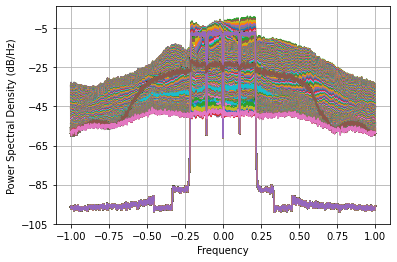

In [ ]:
net = Model(3,7,[[1,0,0,3,0,2,0],[0,1,0,1,0,1,4],[0,0,1,0,1,0,2]])
# net
net=net.to("cuda:0")
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.999)
my_train(train_queue, valid_queue, net, loss_fn, optimizer,102,X,D,scheduler,save_flag=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


Loss =  1.1449913348033369e-05 Accuracy =  -34.45737826703451 dbs
cur_batch =  3000
Loss =  1.2463995220179861e-05 Accuracy =  -34.08882752907396 dbs
cur_batch =  3000
Loss =  9.533606499212465e-06 Accuracy =  -35.25282804285744 dbs
cur_batch =  3000
Loss =  9.680708362665483e-06 Accuracy =  -35.18632889757817 dbs
cur_batch =  3000
Loss =  8.309780134019496e-06 Accuracy =  -35.84950493619564 dbs
cur_batch =  3000
Loss =  8.305942749653697e-06 Accuracy =  -35.85151093364313 dbs
cur_batch =  3000
Loss =  8.209518698426584e-06 Accuracy =  -35.90222330317232 dbs
cur_batch =  3000
Loss =  7.319159088650833e-06 Accuracy =  -36.400788396376754 dbs
cur_batch =  3000
Loss =  8.910939100920667e-06 Accuracy =  -35.54616551062573 dbs
cur_batch =  3000
Loss =  6.955892864752613e-06 Accuracy =  -36.62187142346214 dbs
cur_batch =  3000
Loss =  6.94755306526969e-06 Accuracy =  -36.62708154093695 dbs
cur_batch =  3000
Loss =  7.032211104458646e-06 Accuracy =  -36.57448127062031 dbs
cur_batch =  3000
Lo

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


Loss =  2.9555666201075246e-06 Accuracy =  -40.338992736549955 dbs
cur_batch =  4000
Loss =  2.899328268237685e-06 Accuracy =  -40.42242636785758 dbs
cur_batch =  4000
Loss =  2.7117947978134008e-06 Accuracy =  -40.712832034213164 dbs
cur_batch =  4000
Loss =  2.6010017222326497e-06 Accuracy =  -40.89399386927623 dbs
cur_batch =  4000
Loss =  2.5367873660065985e-06 Accuracy =  -41.0025596058598 dbs
cur_batch =  4000
Loss =  2.494503124840074e-06 Accuracy =  -41.07555974376173 dbs
cur_batch =  4000
Loss =  2.4621689555183237e-06 Accuracy =  -41.132221755211795 dbs
cur_batch =  4000
Loss =  2.433183314999971e-06 Accuracy =  -41.18365196962567 dbs
cur_batch =  4000
Loss =  2.406315851685753e-06 Accuracy =  -41.23187394689719 dbs
cur_batch =  4000
Loss =  2.3785228430457823e-06 Accuracy =  -41.28232700000595 dbs
cur_batch =  4000
Loss =  2.3511072329923438e-06 Accuracy =  -41.33267589126545 dbs
cur_batch =  4000
Loss =  2.5009589801024835e-06 Accuracy =  -41.06433458052989 dbs
cur_batch = 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


Loss =  2.492650903098016e-06 Accuracy =  -41.07878567067041 dbs
cur_batch =  5000
Loss =  2.4516882113240726e-06 Accuracy =  -41.15074787885594 dbs
cur_batch =  5000
Loss =  2.268567675689828e-06 Accuracy =  -41.487882870622855 dbs
cur_batch =  5000
Loss =  2.232405122252005e-06 Accuracy =  -41.55767016354082 dbs
cur_batch =  5000
Loss =  2.1999367036243583e-06 Accuracy =  -41.62129841166993 dbs
cur_batch =  5000
Loss =  2.17332569080646e-06 Accuracy =  -41.67415212875249 dbs
cur_batch =  5000
Loss =  2.1532005454963496e-06 Accuracy =  -41.714555455194954 dbs
cur_batch =  5000
Loss =  2.139633390238938e-06 Accuracy =  -41.742006599912564 dbs
cur_batch =  5000
Loss =  2.1310689189191653e-06 Accuracy =  -41.75942531632738 dbs
cur_batch =  5000
Loss =  2.1253710682953812e-06 Accuracy =  -41.77105262257463 dbs
cur_batch =  5000
Loss =  2.1225610811131432e-06 Accuracy =  -41.77679829864732 dbs
cur_batch =  5000
Loss =  2.1257343514941413e-06 Accuracy =  -41.77031035968818 dbs
cur_batch =  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


Loss =  2.072154062452029e-06 Accuracy =  -41.881179850815286 dbs
cur_batch =  6000
Loss =  2.065548044482114e-06 Accuracy =  -41.89504725603274 dbs
cur_batch =  6000
Loss =  2.0848091206715654e-06 Accuracy =  -41.854737283539414 dbs
cur_batch =  6000
Loss =  2.0937360701734064e-06 Accuracy =  -41.83618091700484 dbs
cur_batch =  6000
Loss =  2.0818854220358576e-06 Accuracy =  -41.86083202544867 dbs
cur_batch =  6000
Loss =  2.0680608724561506e-06 Accuracy =  -41.889767088124 dbs
cur_batch =  6000
Loss =  2.0826084458120185e-06 Accuracy =  -41.859324013914055 dbs
cur_batch =  6000
Loss =  2.137358814843065e-06 Accuracy =  -41.74662590052787 dbs
cur_batch =  6000
Loss =  2.245119858406296e-06 Accuracy =  -41.53300495400135 dbs
cur_batch =  6000
Loss =  2.280180715856216e-06 Accuracy =  -41.46570758289123 dbs
cur_batch =  6000
Loss =  2.2067185181037243e-06 Accuracy =  -41.60793087197007 dbs
cur_batch =  6000
Loss =  2.1446596052614053e-06 Accuracy =  -41.7318165477716 dbs
cur_batch =  60

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


Loss =  2.0100403112493682e-06 Accuracy =  -42.01335259428141 dbs
cur_batch =  7000
Loss =  2.0100755658729016e-06 Accuracy =  -42.01327642290262 dbs
cur_batch =  7000
Loss =  2.010837555840672e-06 Accuracy =  -42.01163038862029 dbs
cur_batch =  7000
Loss =  2.009037939925619e-06 Accuracy =  -42.015518883746516 dbs
cur_batch =  7000
Loss =  2.006128063386477e-06 Accuracy =  -42.0218137345406 dbs
cur_batch =  7000
Loss =  2.0033919090351476e-06 Accuracy =  -42.027741112027435 dbs
cur_batch =  7000
Loss =  2.001242829571131e-06 Accuracy =  -42.03240237829971 dbs
cur_batch =  7000
Loss =  1.9999649402394344e-06 Accuracy =  -42.03517644221258 dbs
cur_batch =  7000
Loss =  2.000003141390308e-06 Accuracy =  -42.035093488805515 dbs
cur_batch =  7000
Loss =  2.0021462297041077e-06 Accuracy =  -42.03044233048245 dbs
cur_batch =  7000
Loss =  2.0075238634367917e-06 Accuracy =  -42.01879310248191 dbs
cur_batch =  7000
Loss =  2.0168310387120185e-06 Accuracy =  -41.99870510244743 dbs
cur_batch =  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


Loss =  2.020177894553384e-06 Accuracy =  -41.9915041208263 dbs
cur_batch =  8000
Loss =  2.010510792083541e-06 Accuracy =  -42.01233618023366 dbs
cur_batch =  8000
Loss =  2.01340165409724e-06 Accuracy =  -42.00609605620868 dbs
cur_batch =  8000
Loss =  2.0308863635950268e-06 Accuracy =  -41.96854403157535 dbs
cur_batch =  8000
Loss =  2.0667981364240898e-06 Accuracy =  -41.89241965406008 dbs
cur_batch =  8000
Loss =  2.0693938728926807e-06 Accuracy =  -41.88696867804041 dbs
cur_batch =  8000
Loss =  2.0330819461371194e-06 Accuracy =  -41.963851428667596 dbs
cur_batch =  8000
Loss =  2.0144464654257243e-06 Accuracy =  -42.00384296328511 dbs
cur_batch =  8000
Loss =  2.0050765105800247e-06 Accuracy =  -42.02409077418449 dbs
cur_batch =  8000
Loss =  1.999251293464155e-06 Accuracy =  -42.03672641021487 dbs
cur_batch =  8000
Loss =  1.9952575154958843e-06 Accuracy =  -42.04541071356462 dbs
cur_batch =  8000
Loss =  1.9923414575043953e-06 Accuracy =  -42.05176254647931 dbs
cur_batch =  80

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


Loss =  1.979898182992382e-06 Accuracy =  -42.07897169609296 dbs
cur_batch =  9000
Loss =  1.980053805219018e-06 Accuracy =  -42.07863034915478 dbs
cur_batch =  9000
Loss =  1.9797076767876176e-06 Accuracy =  -42.07938959522984 dbs
cur_batch =  9000
Loss =  1.9793477595999555e-06 Accuracy =  -42.08017922826977 dbs
cur_batch =  9000
Loss =  1.979010501884908e-06 Accuracy =  -42.08091927833752 dbs
cur_batch =  9000
Loss =  1.978695580561457e-06 Accuracy =  -42.08161042917312 dbs
cur_batch =  9000
Loss =  1.97840116471687e-06 Accuracy =  -42.0822566765871 dbs
cur_batch =  9000
Loss =  1.9781253177937906e-06 Accuracy =  -42.08286225219624 dbs
cur_batch =  9000
Loss =  1.977866314819968e-06 Accuracy =  -42.08343092661689 dbs
cur_batch =  9000
Loss =  1.9776226749584244e-06 Accuracy =  -42.0839659373215 dbs
cur_batch =  9000
Loss =  1.9773931316426923e-06 Accuracy =  -42.08447005361517 dbs
cur_batch =  9000
Loss =  1.977176597062191e-06 Accuracy =  -42.08494565414823 dbs
cur_batch =  9000
Lo

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


Loss =  1.9753447636081402e-06 Accuracy =  -42.08897121224254 dbs
cur_batch =  10000
Loss =  1.9747509236266533e-06 Accuracy =  -42.09027701063051 dbs
cur_batch =  10000
Loss =  1.974538912872349e-06 Accuracy =  -42.09074329750536 dbs
cur_batch =  10000
Loss =  1.9743733390514433e-06 Accuracy =  -42.09110748790627 dbs
cur_batch =  10000
Loss =  1.9742328318535427e-06 Accuracy =  -42.0914165665943 dbs
cur_batch =  10000
Loss =  1.97410921616065e-06 Accuracy =  -42.09168850662717 dbs
cur_batch =  10000
Loss =  1.973998067890258e-06 Accuracy =  -42.091933034331426 dbs
cur_batch =  10000
Loss =  1.97389678970199e-06 Accuracy =  -42.09215585971001 dbs
cur_batch =  10000
Loss =  1.9738036863487756e-06 Accuracy =  -42.09236070945887 dbs
cur_batch =  10000
Loss =  1.973717563295048e-06 Accuracy =  -42.09255020947491 dbs
cur_batch =  10000
Loss =  1.9736375301327187e-06 Accuracy =  -42.092726317070756 dbs
cur_batch =  10000
Loss =  1.97356289434007e-06 Accuracy =  -42.09289055455261 dbs
cur_bat

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


Loss =  1.9731629880126305e-06 Accuracy =  -42.093770661846875 dbs
cur_batch =  11000
Loss =  1.9733073992924297e-06 Accuracy =  -42.09345282329337 dbs
cur_batch =  11000
Loss =  1.9733557736604303e-06 Accuracy =  -42.0933463600855 dbs
cur_batch =  11000
Loss =  1.9733792872948153e-06 Accuracy =  -42.09329461178466 dbs
cur_batch =  11000
Loss =  1.9733935371134137e-06 Accuracy =  -42.09326325139044 dbs
cur_batch =  11000
Loss =  1.97340191328717e-06 Accuracy =  -42.093244817569435 dbs
cur_batch =  11000
Loss =  1.973406413726806e-06 Accuracy =  -42.093234913282544 dbs
cur_batch =  11000
Loss =  1.9734081752369208e-06 Accuracy =  -42.093231036667085 dbs
cur_batch =  11000
Loss =  1.973407928560669e-06 Accuracy =  -42.093231579535725 dbs
cur_batch =  11000
Loss =  1.9734061821917316e-06 Accuracy =  -42.09323542282994 dbs
cur_batch =  11000
Loss =  1.9734033083197136e-06 Accuracy =  -42.093241747466394 dbs
cur_batch =  11000
Loss =  1.9733995880410724e-06 Accuracy =  -42.09324993483489 db

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


Loss =  1.973358347753195e-06 Accuracy =  -42.093340695047445 dbs
cur_batch =  12000
Loss =  1.9732724316243364e-06 Accuracy =  -42.09352978241215 dbs
cur_batch =  12000
Loss =  1.9732034257072073e-06 Accuracy =  -42.09368165912502 dbs
cur_batch =  12000
Loss =  1.9731530899702534e-06 Accuracy =  -42.09379244755843 dbs
cur_batch =  12000
Loss =  1.9731151704545407e-06 Accuracy =  -42.093875909884574 dbs
cur_batch =  12000
Loss =  1.9730848748728422e-06 Accuracy =  -42.093942592788665 dbs
cur_batch =  12000
Loss =  1.973059658261368e-06 Accuracy =  -42.09399809726968 dbs
cur_batch =  12000
Loss =  1.9730380798014733e-06 Accuracy =  -42.09404559435 dbs
cur_batch =  12000
Loss =  1.9730192425355384e-06 Accuracy =  -42.094087058119946 dbs
cur_batch =  12000
Loss =  1.97300255132518e-06 Accuracy =  -42.09412379841655 dbs
cur_batch =  12000
Loss =  1.9729875918732655e-06 Accuracy =  -42.09415672707163 dbs
cur_batch =  12000
Loss =  1.9729740642775125e-06 Accuracy =  -42.094186504148546 dbs
c

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


Loss =  1.9728914114175306e-06 Accuracy =  -42.094368444872224 dbs
cur_batch =  13000
Loss =  1.972819617887912e-06 Accuracy =  -42.09452648753435 dbs
cur_batch =  13000
Loss =  1.972778386791708e-06 Accuracy =  -42.09461725419403 dbs
cur_batch =  13000
Loss =  1.9727546371171405e-06 Accuracy =  -42.094669537890795 dbs
cur_batch =  13000
Loss =  1.972738308027015e-06 Accuracy =  -42.0947054859147 dbs
cur_batch =  13000
Loss =  1.9727256861445872e-06 Accuracy =  -42.09473327283101 dbs
cur_batch =  13000
Loss =  1.9727152027673755e-06 Accuracy =  -42.094756351989986 dbs
cur_batch =  13000
Loss =  1.9727061092351887e-06 Accuracy =  -42.09477637150394 dbs
cur_batch =  13000
Loss =  1.9726980093855652e-06 Accuracy =  -42.09479420349219 dbs
cur_batch =  13000
Loss =  1.9726906737179685e-06 Accuracy =  -42.09481035318093 dbs
cur_batch =  13000
Loss =  1.9726839580243804e-06 Accuracy =  -42.09482513803124 dbs
cur_batch =  13000
Loss =  1.9726777648786514e-06 Accuracy =  -42.094838772517534 dbs

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


Loss =  1.972639538381952e-06 Accuracy =  -42.0949229308009 dbs
cur_batch =  14000


RuntimeError: ignored

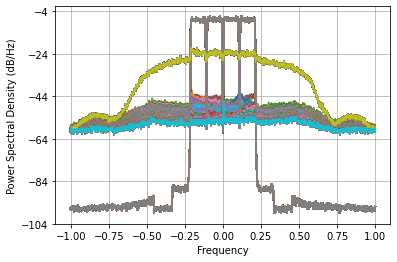

In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.95)
my_train(train_queue, valid_queue, net, loss_fn, optimizer,102,X,D,scheduler,save_flag=False)

In [ ]:
net = Model(1,7,[[13,12,11,14,10,9,6],[7,6,9,10,11,12,7]]) #,[0,0,2,0,1,0,3],[1,4,2,5,1,0,1]
# net
net=net.to("cuda:0")
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.999)
my_train(train_queue, valid_queue, net, loss_fn, optimizer,102,X,D,scheduler,save_flag=True)

In [ ]:
pwd

'/content'

In [ ]:
mkdir new_folder

In [ ]:
from google.colab import files
files.download( "data/dm.ckpt.meta" ) 

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving Lisa_model.pt to Lisa_model.pt
User uploaded file "Lisa_model.pt" with length 45713 bytes


In [ ]:
pwd


'/content'

In [ ]:
model = Model(3,5,[[1,0,0,0,0],[0,1,0,1,0],[0,0,1,0,1]])
model.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/huawei/Lisa_model.pt'))
model.eval()

In [ ]:
net
import pickle
path_to_experiment = './new_folder'
torch.save(net.state_dict(), path_to_experiment + '/model.pt')
# with open(path_to_experiment + '\hist.pkl', 'wb') as output:
#     pickle.dump(hist, output)
#     torch.save(net.state_dict(), path_to_experiment + '\model.pt')

In [ ]:
net = model
net=net.to("cuda:0")
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=1)
train(train_queue, valid_queue, net, loss_fn, optimizer,150,scheduler,save_flag=False)

сохранение нейронной сети

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving lte_2c_data0_in.npy to lte_2c_data0_in.npy
User uploaded file "lte_2c_data0_in.npy" with length 2457728 bytes


In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving lte_2c_data0_out.npy to lte_2c_data0_out.npy
User uploaded file "lte_2c_data0_out.npy" with length 2457728 bytes


In [ ]:
x = np.load('lte_2c_data0_in.npy').reshape(-1,1)/2**15
y = np.load('lte_2c_data0_out.npy').reshape(-1,1)/2**15
d = y - x

x_r, x_im = torch.from_numpy(np.real(x)), torch.from_numpy(np.imag(x))
d_r, d_im = torch.from_numpy(np.real(d)), torch.from_numpy(np.imag(d))

y_r, y_im = torch.from_numpy(np.real(y)), torch.from_numpy(np.imag(y))


X = torch.DoubleTensor(torch.cat((x_r, x_im), dim=1)).reshape(-1,2,1)
Y = torch.DoubleTensor(torch.cat((y_r, y_im), dim=1)).reshape(-1,2,1)
D = torch.DoubleTensor(torch.cat((d_r, d_im), dim=1)).reshape(-1,2,1)

train_queue = torch.utils.data.DataLoader(
    torch.cat((X,D),dim=-1), batch_size=1000)#, pin_memory=True)

valid_queue = torch.utils.data.DataLoader(
    torch.cat((X,D),dim=-1), batch_size=X.shape[0])#,pin_memory=True)

In [ ]:
plt.psd(X.detach().cpu()[:,0,0]+1j*X.detach().cpu()[:,1,0],NFFT=2048)
plt.psd(D.detach().cpu()[:,0,0]+1j*D.detach().cpu()[:,1,0],NFFT=2048)
plt.psd(Y.detach().cpu()[:,0,0]+1j*D.detach().cpu()[:,1,0],NFFT=2048)
plt.show()

In [ ]:

for step, (valid) in enumerate(valid_queue):
    input_batch = Variable(valid[:,:,:1],requires_grad=False).permute(2,1,0).cuda()
    desired = Variable(valid[:,:,1:],requires_grad=False).permute(2,1,0).cuda()
    break

out = net(input_batch)
draw_spectrum(input_batch, desired, out-desired)
accuracy_v = NMSE(input_batch, out-desired)

print('Accuracy = ', accuracy_v.cpu().detach().numpy(), 'dbs')

In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=1)
train(train_queue, valid_queue, net, loss_fn, optimizer,50,scheduler,save_flag=False)

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving lte_10c_data0_in.npy to lte_10c_data0_in.npy
User uploaded file "lte_10c_data0_in.npy" with length 3932288 bytes


In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving lte_10c_data0_out.npy to lte_10c_data0_out.npy
User uploaded file "lte_10c_data0_out.npy" with length 3932288 bytes


In [ ]:
x = np.load('lte_10c_data0_in.npy').reshape(-1,1)/2**15
y = np.load('lte_10c_data0_out.npy').reshape(-1,1)/2**15
d = y - x

# print(x[0])

# plt.psd(x, NFFT = 2048)
# plt.psd(y, NFFT = 2048)
# plt.psd(d, NFFT = 2048)

x_r, x_im = torch.from_numpy(np.real(x)), torch.from_numpy(np.imag(x))
d_r, d_im = torch.from_numpy(np.real(d)), torch.from_numpy(np.imag(d))

X = torch.DoubleTensor(torch.cat((x_r, x_im), dim=1)).reshape(-1,2,1)
D = torch.DoubleTensor(torch.cat((d_r, d_im), dim=1)).reshape(-1,2,1)

train_queue = torch.utils.data.DataLoader(
    torch.cat((X,D),dim=-1), batch_size=5000)#, pin_memory=True)

valid_queue = torch.utils.data.DataLoader(
    torch.cat((X,D),dim=-1), batch_size=X.shape[0])#,pin_memory=True)

In [ ]:
plt.psd(X.detach().cpu()[:,0,0]+1j*X.detach().cpu()[:,1,0],NFFT=2048)
plt.psd(D.detach().cpu()[:,0,0]+1j*D.detach().cpu()[:,1,0],NFFT=2048)
plt.show()

In [ ]:
#net = model
net=net.to("cuda:0")
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.99)
train(train_queue, valid_queue, net, loss_fn, optimizer,50,scheduler,save_flag=False)

In [ ]:
def draw_spectrum(input_batch,desired,out):
  plt.psd(input_batch.detach().cpu()[0,0,:]+
                1j*input_batch.detach().cpu()[0,1,:],NFFT=2048)
  plt.psd(desired.detach().cpu()[0,0,:]+
                1j*desired.detach().cpu()[0,1,:],NFFT=2048)
        # plt.psd(desired.permute(2,1,0).detach().cpu().reshape(-1,),NFFT=2048)
  plt.psd((out-desired).detach().cpu()[0,0,:]+
                1j*(out-desired).detach().cpu()[0,1,:],NFFT=2048)
        # plt.psd((out-desired).permute(2,1,0).detach().cpu().reshape(-1,),NFFT=2048)
  plt.show()

In [ ]:

for step, (valid) in enumerate(valid_queue):
    input_batch = Variable(valid[:,:,:1],requires_grad=False).permute(2,1,0).cuda()
    desired = Variable(valid[:,:,1:],requires_grad=False).permute(2,1,0).cuda()
    break

out = net(input_batch)
draw_spectrum(input_batch, desired, out-desired)

accuracy_v = NMSE(input_batch, out)

print('Accuracy = ', accuracy_v.cpu().detach().numpy(), 'dbs')